In [7]:
import pandas as pd
from category_encoders import TargetEncoder

# ============================
# 1. Load cleaned datasets
# ============================
train_df = pd.read_csv("/Users/riadanas/Desktop/housing regression MLE/data/processed/cleaning_train.csv")
eval_df = pd.read_csv("/Users/riadanas/Desktop/housing regression MLE/data/processed/cleaning_eval.csv")
holdout_df = pd.read_csv("/Users/riadanas/Desktop/housing regression MLE/data/processed/cleaning_holdout.csv")

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows

print("Train date range:", train_df["date"].min(), "to", train_df["date"].max())
print("Eval date range:", eval_df["date"].min(), "to", eval_df["date"].max())
print("Holdout date range:", holdout_df["date"].min(), "to", holdout_df["date"].max())

# Ensure datetime
train_df["date"] = pd.to_datetime(train_df["date"])
eval_df["date"] = pd.to_datetime(eval_df["date"])
holdout_df["date"] = pd.to_datetime(holdout_df["date"])

Train date range: 2012-03-31 to 2019-12-31
Eval date range: 2020-01-31 to 2021-12-31
Holdout date range: 2022-01-31 to 2023-12-31


In [8]:
# ============================
# 2. Date Features
# ============================
def add_date_features(df):
    df["year"] = df["date"].dt.year
    df["quarter"] = df["date"].dt.quarter
    df["month"] = df["date"].dt.month

    # Reorder columns
    df.insert(1, "year", df.pop("year"))
    df.insert(2, "quarter", df.pop("quarter"))
    df.insert(3, "month", df.pop("month"))
    return df

train_df = add_date_features(train_df)
eval_df = add_date_features(eval_df)
holdout_df = add_date_features(holdout_df)

In [9]:
print(train_df.shape)
train_df.head(1)

(576815, 43)


,date,year,quarter,month,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,city,zipcode,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full,lat,lng
0,2012-03-31,2012,1,3,46550.0,217450.0,31.813674,110.183666,14.0,23.0,44.0,64.0,59.5,0.943662,0.142857,0.043478,ATL,30002,12.0,2.0,4.0,1.0,60.0,45.0,57.0,4.0,7.0,5811.0,36.3,33052.0,5811.0,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,200773.999557,atlanta-sandy springs-roswell,33.7338,-84.3922


In [10]:
print(eval_df.shape)
eval_df.head(1)

(148448, 43)


,date,year,quarter,month,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,city,zipcode,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full,lat,lng
0,2020-01-31,2020,1,1,184000.0,168450.0,123.333333,109.8998,35.0,30.0,34.0,37.0,50.0,0.954732,0.171429,0.3,CHI,60482,3.0,0.0,2.0,0.0,68.0,30.0,60.0,5.0,14.0,10849.0,42.1,27037.0,10795.0,4598.0,964.0,169000.0,5690.0,414.0,10573.0,10573.0,5089.0,164839.734849,chicago-naperville-elgin,41.6675,-87.9597


In [11]:
print(holdout_df.shape)
holdout_df.head(1)

(148943, 43)


,date,year,quarter,month,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,city,zipcode,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full,lat,lng
0,2022-01-31,2022,1,1,340000.0,349999.0,189.867865,195.526649,282.0,287.0,241.0,73.0,12.0,0.991177,0.308511,0.634146,ORL,32771,9.0,0.0,1.0,1.0,56.0,64.0,18.0,4.0,9.0,57074.0,37.7,33896.0,56681.0,22246.0,1289.0,261800.0,29485.0,1469.0,55621.0,55621.0,24381.0,314667.746005,orlando-kissimmee-sanford,28.4343,-81.363


The key rule:

- Fit encoders/transformers on train only

- Apply the learned mappings to eval

🎯 Why this matters

- If we had fit the encoders/scalers on both train + eval together:

- Eval would leak information into training.

- Our metrics would look artificially good, because the model would unknowingly benefit from seeing the future.

By strictly fitting on train and applying to eval:

- Eval stays a true proxy for unseen future data.

- The performance you see is realistic for when you deploy the model in the wild.

In [12]:
# ============================
# 3. Frequency Encoding (zipcode)
# ============================
zip_counts = train_df["zipcode"].value_counts()

train_df["zipcode_freq"] = train_df["zipcode"].map(zip_counts)
eval_df["zipcode_freq"] = eval_df["zipcode"].map(zip_counts).fillna(0)
holdout_df["zipcode_freq"] = holdout_df["zipcode"].map(zip_counts).fillna(0)

print("Zip freq example (train):")
print(train_df[["zipcode", "zipcode_freq"]].head())


'''
🔍 Nuance:

- On train, we build the frequency dictionary (zip_counts).
- On eval, we never compute new counts → we only look up in the dictionary.
- If eval has an unseen zipcode, it gets NaN, which we replace with 0.
'''

Zip freq example (train):
   zipcode  zipcode_freq
0    30002            94
1    15469            86
2    15464            85
3     2739            94
4    15461            94


'\n🔍 Nuance:\n\n- On train, we build the frequency dictionary (zip_counts).\n- On eval, we never compute new counts → we only look up in the dictionary.\n- If eval has an unseen zipcode, it gets NaN, which we replace with 0.\n'

In [13]:
# ============================
# 4. Target Encoding (city_full)
# ============================
te = TargetEncoder(cols=["city_full"])

train_df["city_encoded"] = te.fit_transform(train_df["city_full"], train_df["price"])
eval_df["city_encoded"] = te.transform(eval_df["city_full"])
holdout_df["city_encoded"] = te.transform(holdout_df["city_full"])

print("City encoding example (train):")
print(train_df[["city_full", "city_encoded"]].head())

'''
🔍 Nuance:

- On train, we call fit_transform() → this computes the mapping from city → avg price using training targets.
- On eval, we only call transform() → it applies the train mapping. It never looks at eval’s price column.
'''

City encoding example (train):
                       city_full   city_encoded
0  atlanta-sandy springs-roswell  192627.058387
1                     pittsburgh  131828.753854
2                     pittsburgh  131828.753854
3        boston-cambridge-newton  472075.429542
4                     pittsburgh  131828.753854


'\n🔍 Nuance:\n\n- On train, we call fit_transform() → this computes the mapping from city → avg price using training targets.\n- On eval, we only call transform() → it applies the train mapping. It never looks at eval’s price column.\n'

In [14]:
# ============================
# 5. Drop unused columns
# ============================
# Drop leakage column "median_sale_price"
drop_cols = ["date", "city_full", "city", "zipcode", "median_sale_price"]
train_df.drop(columns=drop_cols, inplace=True)
eval_df.drop(columns=drop_cols, inplace=True)
holdout_df.drop(columns=drop_cols, inplace=True)

In [15]:
print(train_df.shape)
train_df.head(1)

(576815, 40)


,year,quarter,month,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,lat,lng,zipcode_freq,city_encoded
0,2012,1,3,217450.0,31.813674,110.183666,14.0,23.0,44.0,64.0,59.5,0.943662,0.142857,0.043478,12.0,2.0,4.0,1.0,60.0,45.0,57.0,4.0,7.0,5811.0,36.3,33052.0,5811.0,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,200773.999557,33.7338,-84.3922,94,192627.058387


In [16]:
print(eval_df.shape)
eval_df.head(1)

(148448, 40)


,year,quarter,month,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,lat,lng,zipcode_freq,city_encoded
0,2020,1,1,168450.0,123.333333,109.8998,35.0,30.0,34.0,37.0,50.0,0.954732,0.171429,0.3,3.0,0.0,2.0,0.0,68.0,30.0,60.0,5.0,14.0,10849.0,42.1,27037.0,10795.0,4598.0,964.0,169000.0,5690.0,414.0,10573.0,10573.0,5089.0,164839.734849,41.6675,-87.9597,94.0,221986.823469


In [17]:
# ============================
# 6. Save feature-engineered datasets
# ============================
train_df.to_csv("/Users/riadanas/Desktop/housing regression MLE/data/processed/feature_engineered_train.csv", index=False)
eval_df.to_csv("/Users/riadanas/Desktop/housing regression MLE/data/processed/feature_engineered_eval.csv", index=False)
holdout_df.to_csv("/Users/riadanas/Desktop/housing regression MLE/data/processed/feature_engineered_holdout.csv", index=False)

print("✅ Feature engineering complete.")
print("Train shape:", train_df.shape)
print("Eval shape:", eval_df.shape)
print("Holdout shape:", holdout_df.shape)

✅ Feature engineering complete.
Train shape: (576815, 40)
Eval shape: (148448, 40)
Holdout shape: (148943, 40)


- Fit frequency encoding on train only, apply to eval (with fillna(0) in case eval has unseen zipcodes).

- Fit target encoding on train only, apply to eval with the same mapping.

- Added a helper add_date_features so date feature logic isn’t duplicated.

- Dropped unused columns consistently from both datasets 

- Droped high correlated column "median_sale_price"

- Saved two separate outputs:

- feature_engineered_train.csv

- feature_engineered_eval.csv

✅ So the nuance is:

- Train → fit transformations (learn rules from the past).

- Eval → transform with those rules (apply them to future data).

- Never re-fit on eval. That’s what keeps eval “unseen” and leakage-free.

## Multicolinearity

to look at multicolinearity we can use:
- VIF
- Correlation matrix

In [18]:
df = train_df 

In [19]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_vif(df, target_col=None):
    """
    Calculate Variance Inflation Factor (VIF) for each numeric column in df.
    """
    # Keep only numeric columns
    numeric_df = df.select_dtypes(include=['float64', 'int64']).copy()

    # Drop target if provided
    if target_col and target_col in numeric_df.columns:
        numeric_df = numeric_df.drop(columns=[target_col])

    # Add constant for statsmodels
    X = add_constant(numeric_df)

    # Compute VIF (skip the first column = constant)
    vif_data = pd.DataFrame()
    vif_data["feature"] = numeric_df.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i + 1)  # skip constant at index 0
        for i in range(len(numeric_df.columns))
    ]

    return vif_data.sort_values("VIF", ascending=False).reset_index(drop=True)


# Look at VIF and correlation with original training dataset
df = pd.read_csv("/Users/riadanas/Desktop/housing regression MLE/data/raw/train.csv")
vif_table = calculate_vif(df, target_col="price")
print(vif_table)


/Users/riadanas/Desktop/housing regression MLE/.venv/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                         feature          VIF
0        Total School Enrollment          inf
1    Total School Age Population          inf
2               Total Population  6600.440350
3              Total Labor Force   839.557009
4            Median Commute Time   650.528668
5   Total Families Below Poverty   573.705680
6            Total Housing Units    21.298479
7                   new_listings    19.930888
8                     homes_sold    13.409262
9          Unemployed Population    12.881559
10                    restaurant    10.915101
11                          bank    10.680631
12                   supermarket     9.630326
13                 pending_sales     9.241440
14             Median Home Value     6.826955
15                     inventory     5.887100
16                          park     5.676253
17                        school     5.657422
18                       station     4.654858
19             Per Capita Income     4.619926
20                   Median Rent  

How to interpret

- IF > 10 → serious multicollinearity.

- VIF > 100 → catastrophic (drop/re-engineer immediately).

- VIF = ∞ → perfect linear redundancy (drop one).

In [20]:
offenders = ["Total Population", "Total Labor Force", "Total Families Below Poverty"]
corr_matrix = df[offenders].corr()
corr_matrix

,Total Population,Total Labor Force,Total Families Below Poverty
Total Population,1.000000,0.985715,0.998992
Total Labor Force,0.985715,1.000000,0.985703
Total Families Below Poverty,0.998992,0.985703,1.000000


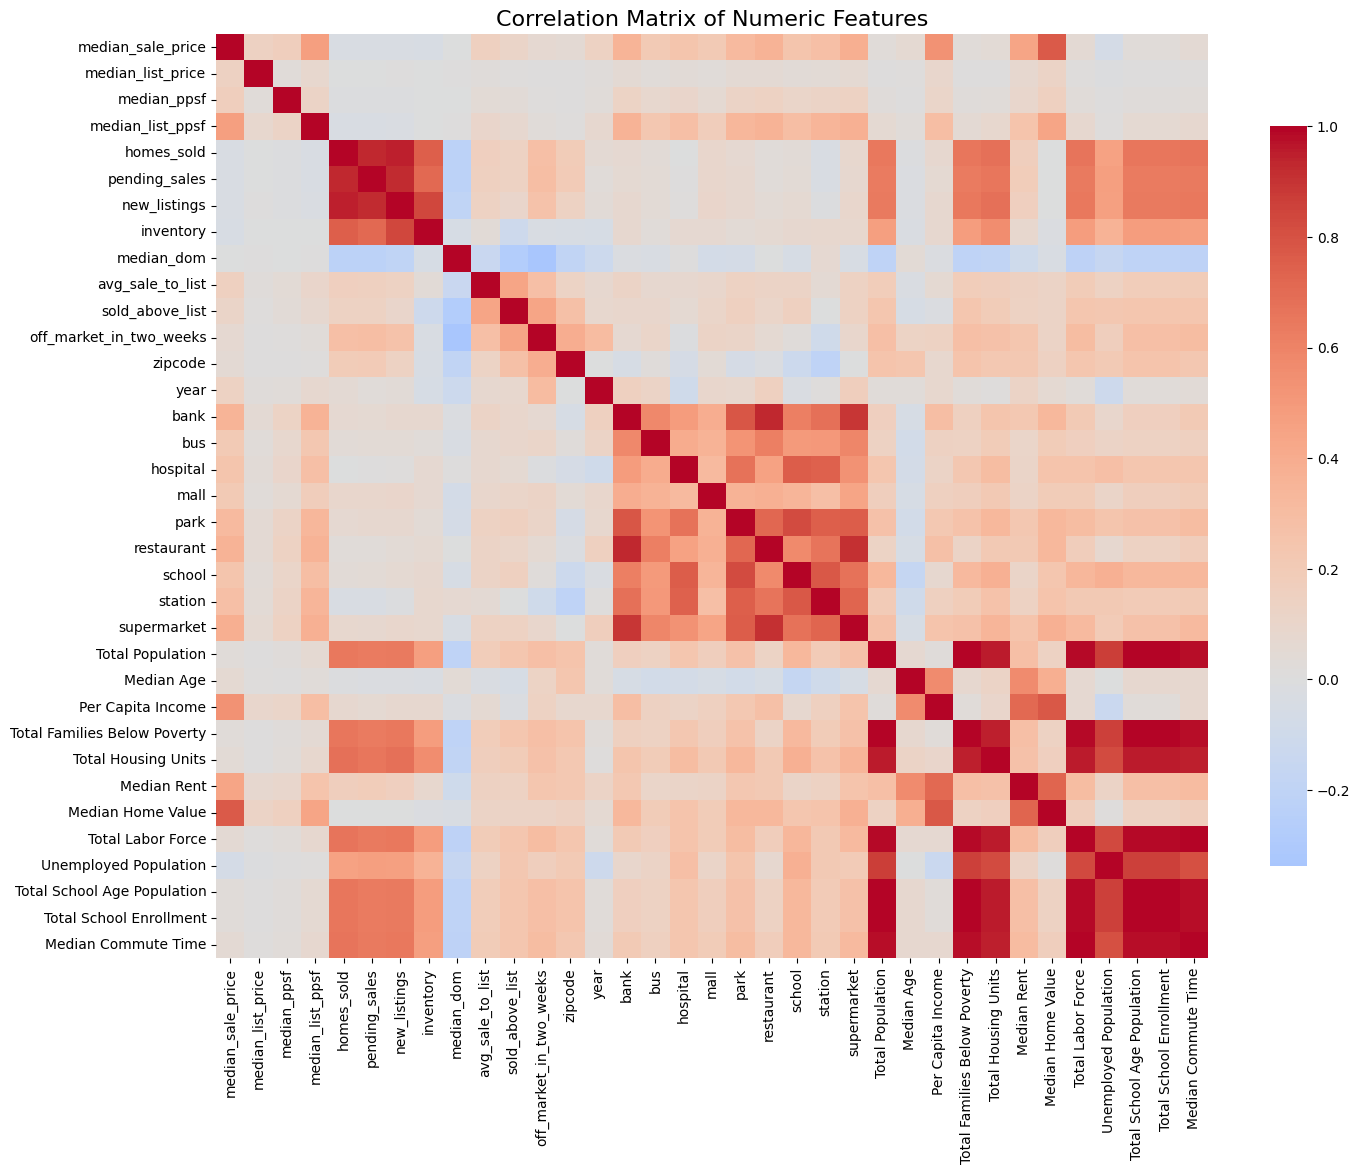

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric features (exclude the target 'price')
numeric_df = df.select_dtypes(include=['float64', 'int64']).drop(columns=["price"], errors="ignore")

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Display full matrix as heatmap
plt.figure(figsize=(16,12))
sns.heatmap(
    corr_matrix, 
    cmap="coolwarm", 
    center=0, 
    annot=False,   # set to True if you want numbers on cells
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.show()


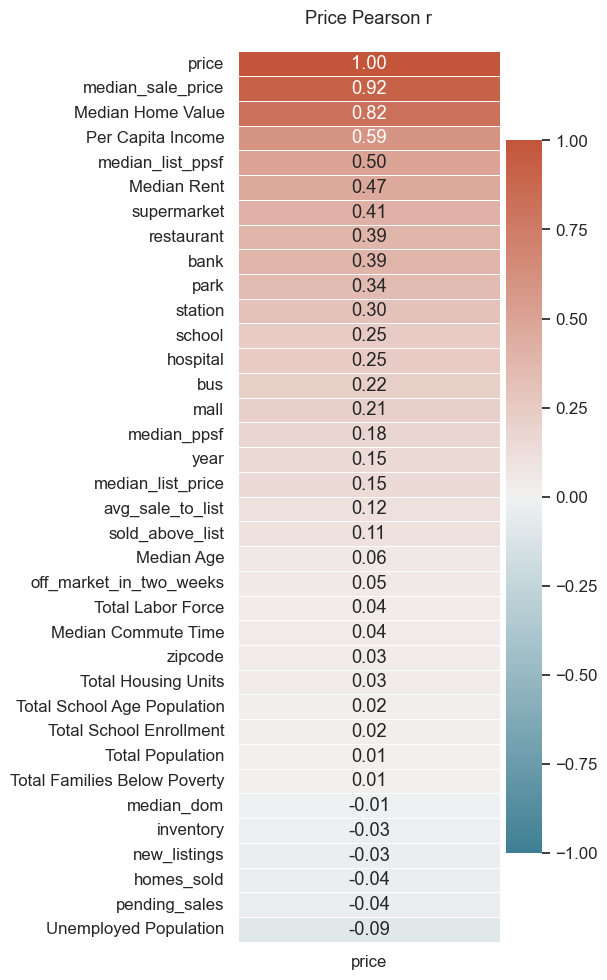

In [22]:
# Compute correlations with price
num_cols = df.select_dtypes("number").columns
corr_vec  = df[num_cols].corr(method="pearson")["price"].sort_values(ascending=False)
sns.set_theme(style="white")     
sns.set(font_scale=1.1)          
plt.figure(figsize=(6,10))       
ax = sns.heatmap(
        corr_vec.to_frame(),     
        annot=True, fmt=".2f",
        vmin=-1, vmax=1,         
        cmap=sns.diverging_palette(220, 20, as_cmap=True),
        center=0,
        linewidths=.5, linecolor="white",
        cbar_kws={"shrink":0.8, "pad":0.02}
     )
ax.set_title("Price Pearson r", pad=20)
ax.set_ylabel("")                 
ax.set_xlabel("")
plt.tight_layout()
plt.show()